In [6]:
# Step 1: Load Dataset
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

file_path = "C:/Users/User/UKM - Nur Azlin Binti Rusnan/Sem 3/Capstone Project/Dataset/2. Predictive Modeling Dataset/PM 18-12/PM-3.xlsx"
xls = pd.ExcelFile(file_path)

# Load the data from the first sheet
df = pd.read_excel(xls, sheet_name='Sheet1')

In [7]:
# Step 2: Preprocess the Sentiment Data for BERT
from sklearn.model_selection import train_test_split

# Map sentiment labels to numerical values
sentiment_mapping = {
    'Very Dissatisfied': 0,
    'Dissatisfied': 1,
    'Neutral': 2,
    'Satisfied': 3,
    'Very Satisfied': 4
}
df['Sentiment_Label'] = df['String value'].map(sentiment_mapping)

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["USS Comment"], df["Sentiment_Label"], test_size=0.2, stratify=df["Sentiment_Label"]
)

# Check distribution
print(train_texts.head(), train_labels.head())

1148    quick responseassistance highly appreciated th...
516                        well done very quick effective
721                     fast friendly efficient thank you
82                              thanks lot prompt support
445                               thank you usual support
Name: USS Comment, dtype: object 1148    4
516     4
721     0
82      4
445     4
Name: Sentiment_Label, dtype: int64


In [8]:
# Step 3: Fine-Tune BERT for Sentiment Analysis
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = BertForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", num_labels=len(sentiment_mapping))

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

# Encode the data
def encode_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    encodings['labels'] = torch.tensor(list(labels))
    return encodings

train_encodings = encode_data(train_texts, train_labels, tokenizer)
val_encodings = encode_data(val_texts, val_labels, tokenizer)

train_dataset = CustomDataset(train_encodings)
val_dataset = CustomDataset(val_encodings)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained("bert_sentiment_model2")
tokenizer.save_pretrained("bert_sentiment_model2")


Epoch,Training Loss,Validation Loss
1,No log,0.395696
2,No log,0.399914


('bert_sentiment_model2\\tokenizer_config.json',
 'bert_sentiment_model2\\special_tokens_map.json',
 'bert_sentiment_model2\\vocab.txt',
 'bert_sentiment_model2\\added_tokens.json')

In [9]:
# Step 4: Feature Engineering for Predictive Modeling
# Frequency encoding for Country
country_freq = df['Country'].value_counts(normalize=True).to_dict()
df['Country_Freq'] = df['Country'].map(country_freq)

# One-hot encoding for Region
region_encoded = pd.get_dummies(df['Region'], prefix='Region')
df = pd.concat([df, region_encoded], axis=1)

# Add predicted sentiment labels (placeholder until BERT is applied)
df['Predicted_Sentiment'] = df['Sentiment_Label']
df['Confidence'] = 1.0  # Placeholder for confidence

# Prepare feature set and target
X = df[['Country_Freq'] + list(region_encoded.columns) + ['Predicted_Sentiment', 'Confidence']]
y = df['Average Response (calculated)']

In [11]:
# Step 5: Predictive Modeling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import shap

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models to evaluate
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# Evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Results:")
    print(f"MAE: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}")


Training Random Forest...
Random Forest Results:
MAE: 0.0000
Mean Squared Error: 0.0000
RMSE: 0.0000
R-squared: 1.0000

Training Gradient Boosting...
Gradient Boosting Results:
MAE: 0.0000
Mean Squared Error: 0.0000
RMSE: 0.0000
R-squared: 1.0000

Training Support Vector Regressor...
Support Vector Regressor Results:
MAE: 0.0969
Mean Squared Error: 0.0097
RMSE: 0.0983
R-squared: 0.9916


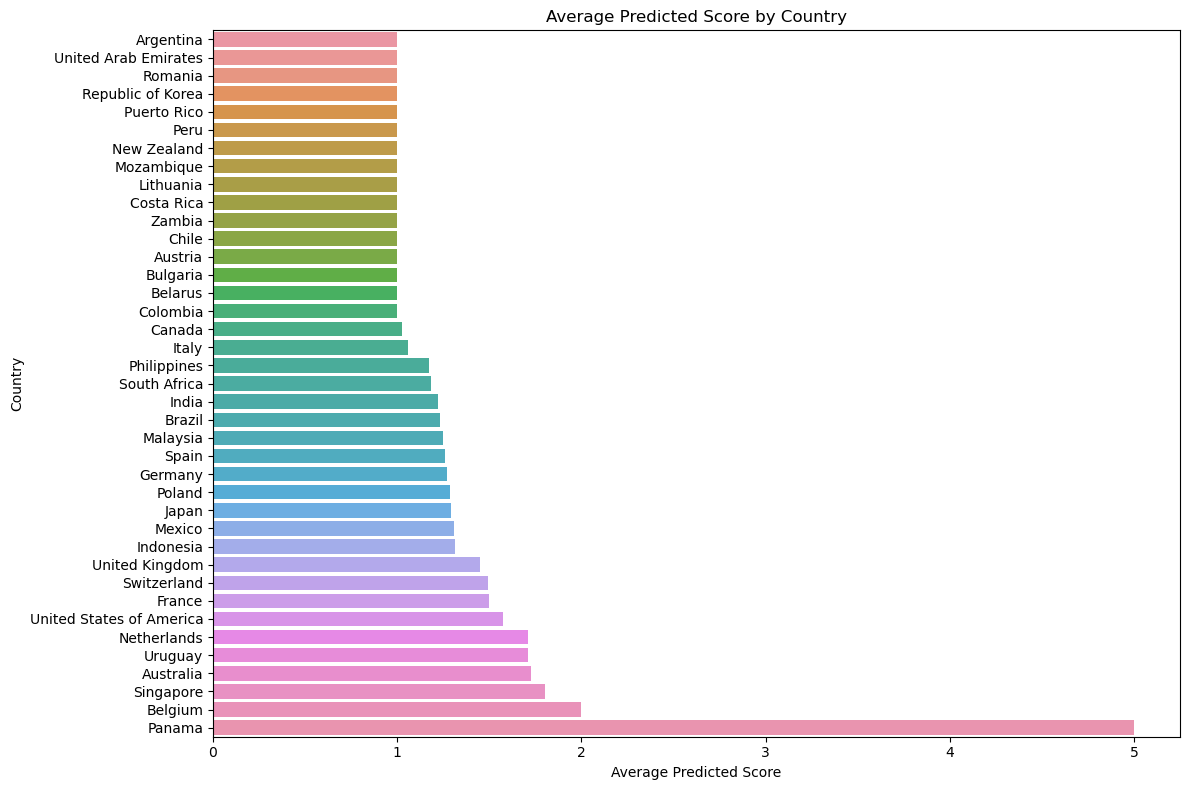

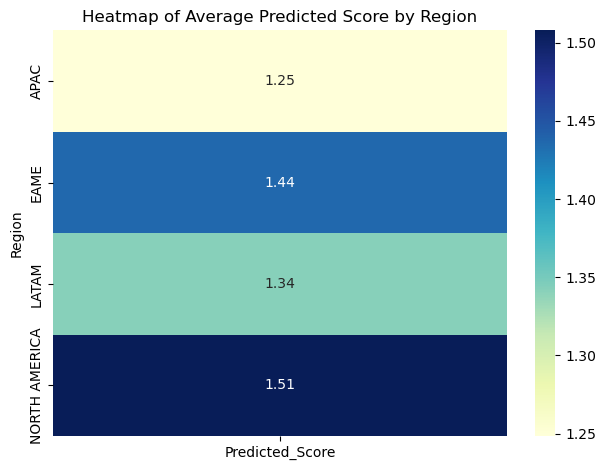

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Calculate average predicted response by Country
df['Predicted_Score'] = models['Random Forest'].predict(X)  # Replace with your preferred model
country_avg_pred = df.groupby('Country')['Predicted_Score'].mean().sort_values()

# Bar chart for Country
plt.figure(figsize=(12, 8))
sns.barplot(x=country_avg_pred.values, y=country_avg_pred.index)
plt.title("Average Predicted Score by Country")
plt.xlabel("Average Predicted Score")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Heatmap for Region (example)
region_avg_pred = df.pivot_table(index='Region', values='Predicted_Score', aggfunc='mean')
sns.heatmap(region_avg_pred, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of Average Predicted Score by Region")
plt.tight_layout()
plt.show()



In [27]:
# Step 6: Save and Load Random Forest Model
from joblib import dump, load

# Use Random Forest as the final model
rf_model = models['Random Forest']

# Save the trained model
dump(rf_model, "random_forest_model.pkl")
print("Random Forest model saved as 'random_forest_model.pkl'.")

from transformers import BertTokenizer, BertForSequenceClassification

# Load the fine-tuned BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert_sentiment_model2")
sentiment_model = BertForSequenceClassification.from_pretrained("bert_sentiment_model2")

# Function to make predictions for new inputs
def predict_final_csat(comment, country, region, sentiment_model, tokenizer):
    """
    Predict the final CSAT score for a given input.
    """
    # Step 1: Predict Sentiment Score using the BERT model
    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = sentiment_model(**inputs)
    sentiment_score = torch.argmax(outputs.logits).item()
    confidence = torch.max(torch.softmax(outputs.logits, dim=1)).item()
    
    # Step 2: Frequency encode country
    country_freq = df['Country'].value_counts(normalize=True).to_dict()
    country_contribution = country_freq.get(country, 0)
    
    # Step 3: One-hot encode region
    region_columns = list(region_encoded.columns)
    region_values = [1 if f"Region_{region}" == col else 0 for col in region_columns]
    
    # Step 4: Combine features
    input_features = [country_contribution] + region_values + [sentiment_score, confidence]
    
    # Step 5: Load the saved model and predict
    loaded_model = load("random_forest_model.pkl")
    predicted_csat = loaded_model.predict([input_features])[0]
    
    # Step 6: Calculate average CSAT score for the given country and region
    country_avg_csat = df[df['Country'] == country]['Predicted_Score'].mean()
    region_avg_csat = df[df['Region'] == region]['Predicted_Score'].mean()
    
    # Handle cases where the country or region is not present in the dataset
    country_avg_csat = country_avg_csat if not pd.isna(country_avg_csat) else 0
    region_avg_csat = region_avg_csat if not pd.isna(region_avg_csat) else 0
    
    # Return results
    return {
        "Comment Contribution (Sentiment Score)": sentiment_score,
        "Country Contribution (Frequency)": country_contribution,
        "Region Contribution (One-Hot)": dict(zip(region_columns, region_values)),
        "Average Predicted CSAT for Country": country_avg_csat,
        "Average Predicted CSAT for Region": region_avg_csat,
        "Final Predicted CSAT Score": predicted_csat
    }

# user input
example_comment = "perfecto"  
example_country = "Uruguay"
example_region = "LATAM"

# Prediction 
final_result = predict_final_csat(example_comment, example_country, example_region, sentiment_model, tokenizer)

print("\nPrediction Result:")
print(f"{'Component':<40} {'Value':<30}")
print("-" * 70)
print(f"{'Comment Contribution (Sentiment Score)':<40} {final_result['Comment Contribution (Sentiment Score)']:<30}")
print(f"{'Country Contribution (Frequency)':<40} {final_result['Country Contribution (Frequency)']:<30}")
print(f"{'Region Contribution (One-Hot)':<40} {final_result['Region Contribution (One-Hot)']}")
print(f"{'Average Predicted CSAT for Country':<40} {final_result['Average Predicted CSAT for Country']:<30}")
print(f"{'Average Predicted CSAT for Region':<40} {final_result['Average Predicted CSAT for Region']:<30}")
print(f"{'Final Predicted CSAT Score':<40} {final_result['Final Predicted CSAT Score']:<30}")

Random Forest model saved as 'random_forest_model.pkl'.

Prediction Result:
Component                                Value                         
----------------------------------------------------------------------
Comment Contribution (Sentiment Score)   4                             
Country Contribution (Frequency)         0.01744186046511628           
Region Contribution (One-Hot)            {'Region_APAC': 0, 'Region_EAME': 0, 'Region_LATAM': 1, 'Region_NORTH AMERICA': 0}
Average Predicted CSAT for Country       1.7083333333333333            
Average Predicted CSAT for Region        1.3425925925925926            
Final Predicted CSAT Score               1.0                           
